<a href="https://colab.research.google.com/github/GrzegorzSzczepanek/deep_learning_fun/blob/main/training_on_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch import nn
n_samples = 1000

X, y = make_moons(n_samples,
                  noise=0.03,
                  random_state=42)

# X_train, y_train = X[:n_samples * 0.8], y[:n_samples * 0.8]
# X_test, y_test = X[n_samples * 0.8: ], y[n_samples * 0.8 :]

#len(X_train), len(X_test), len(y_train), len(y_test)

In [2]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0
5,0.579542,-0.352979,1
6,0.294884,-0.209238,1
7,-0.014488,0.435896,1
8,1.626510,-0.281207,1
9,0.671598,0.786422,0


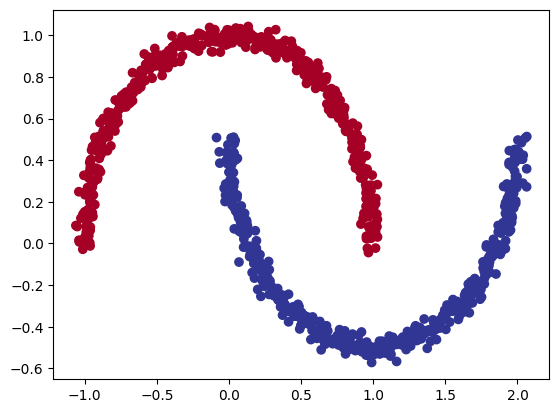

In [3]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [4]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[-0.0093,  0.3910],
         [ 0.9546, -0.4738],
         [ 0.9185, -0.4252],
         [ 0.4128, -0.3764],
         [-0.8453,  0.5288]]),
 tensor([1., 1., 1., 1., 0.]))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
class MoonModel(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.layer_block_1 = nn.Sequential(
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units)
    )
    self.layer_block_2 = nn.Sequential(
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_block_2(self.layer_block_1(x))


model = MoonModel(2, 10, 1).to(device)
model

MoonModel(
  (layer_block_1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
  )
  (layer_block_2): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [13]:
loss_fn = torch.nn.BCELoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01)

In [14]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [15]:
# def train_step(model: torch.nn.Module,
#                loss_fn: torch.nn,
#                optimizer: torch.optim.Optimizer,
#                accuracy_fn,
#                data,
#                predictions):
#   model.train()
#   y_logits = model(X_train).squeeze()
#   y_pred = torch.round(torch.sigmoid(y_logits))

#   loss = loss_fn(y_logits, y_train)
#   acc = accu

In [16]:
epochs = 1001

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

from tqdm.auto import tqdm

for epoch in tqdm(range(epochs)):
  model.train()
  y_logits = model(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_train)
  y_pred = accuracy_fn(y_true=y_train,
                       y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    y_pred = accuracy_fn(y_true=y_train,
                         y_pred=y_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

  0%|          | 0/1001 [00:00<?, ?it/s]

RuntimeError: ignored